# Import

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import re


# Load Data

In [5]:
file_dir = "/Users/huayinluo/Desktop/code/natconv"
csv1 = pd.read_csv(f"{file_dir}/combinedSurvey.csv")
csv1 = csv1.rename(columns={'convo_id': 'conversation'}) # rename column
csv2 = pd.read_csv(f"{file_dir}/backchannel.csv")
df = pd.merge(csv1, csv2, on='conversation') # merge based on conversation id
df = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y']) # drop columns

In [35]:
df["backchannel_count"] = df["backchannel_given"] + df["backchannel_recieved"]

In [36]:
df.to_csv(f"{file_dir}/natconv.csv")

In [37]:
df.head()

,user_id,partner_id,conversation,date,survey_duration_in_seconds,time_zone,pre_affect,pre_arousal,technical_quality,conv_length,...,your_agreeable,your_conscientious,your_neurotic,your_open,who_i_talked_to_most_past24,most_common_format_past24,speaker,backchannel_given,backchannel_recieved,backchannel_count
0,5a73899f9cdd1800017786f0,5fa072f4f4aa580b63834357,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,4115,6.0,5.0,4.0,1.0,45.0,...,4.000000,4.666667,3.000000,4.666667,NaN,NaN,5a73899f9cdd1800017786f0,269,83,352
1,5a73899f9cdd1800017786f0,5fa072f4f4aa580b63834357,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,4115,6.0,5.0,4.0,1.0,45.0,...,4.000000,4.666667,3.000000,4.666667,NaN,NaN,5fa072f4f4aa580b63834357,83,269,352
2,5fa072f4f4aa580b63834357,5a73899f9cdd1800017786f0,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,3949,6.0,7.0,6.0,1.0,43.0,...,4.000000,4.333333,2.666667,3.666667,NaN,NaN,5a73899f9cdd1800017786f0,269,83,352
3,5fa072f4f4aa580b63834357,5a73899f9cdd1800017786f0,0020a0c5-1658-4747-99c1-2839e736b481,2020-11-10,3949,6.0,7.0,6.0,1.0,43.0,...,4.000000,4.333333,2.666667,3.666667,NaN,NaN,5fa072f4f4aa580b63834357,83,269,352
4,5f482b0da1cde52de45f174c,5f57120cba207c18f058a62b,002d68da-7738-4177-89d9-d72ae803e0e4,2020-11-15,3293,8.0,7.0,6.0,1.0,34.0,...,3.666667,2.666667,4.000000,4.000000,NaN,NaN,5f482b0da1cde52de45f174c,76,96,172


In [107]:
datadict = pd.read_csv("datadict.csv")
datadict

,column,text,sub_questions,type,selector,sub_selector,choices,notes
0,user_id,The ID of the respondent.,NaN,NaN,NaN,NaN,NaN,NaN
1,partner_id,The ID of the respondent's partner.,NaN,NaN,NaN,NaN,NaN,NaN
2,convo_id,The ID of the conversation.,NaN,NaN,NaN,NaN,NaN,NaN
3,date,The date of the survey.,NaN,NaN,NaN,NaN,NaN,NaN
4,survey_duration_in_seconds,Amount of time taken to complete the survey.,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
224,your_conscientious,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
225,your_neurotic,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
226,your_open,"Now, please tell us where you think your conve...","tends to be quiet, is compassionate, has a sof...",matrix table,likert,single answer question,"1 - Disagree strongly, 2 - Disagree a little, ...",NaN
227,who_i_talked_to_most_past24,Who were your conversations with? In other wor...,none,constant sum,number entry,text box,"Family, Romantic Partner, Friends, Work Collea...",NaN


In [151]:
datadict.groupby("text").count().sort_values("column", ascending=False)["column"].index[:20] # get questions with most subquestions


Index(['Now, please tell us where you think your conversation partner falls on these items. My conversation partner is...',
       'I am someone who...',
       'How would you rate yourself on each of the following traits?',
       'Please rate your agreement with the following statements about you and your conversation partner: During our interaction....',
       'What format did your conversations take? To answer, please tell us what percentage of your conversations were in each of the following formats (e.g., if 100% of your conversations were in person, enter the number 100 in the In Person box below)(Your total must add up to 100%)',
       'To what extent does your conversation partner have each of the following traits?',
       'To what extent do you have each of the following traits?',
       'Evaluate your conversation partner on the following traits.',
       'Rate the extent to which you agree with the following statements:',
       'Who were your conversations with? In othe

In [136]:
from itertools import groupby
likert = datadict[datadict["selector"]=="likert"]["column"]
likert = [list(g) for k, g in groupby(likert, key=lambda x: x[:2])]
for lst in likert:
    print(lst)


['i_felt_close_to_my_partner', 'i_would_like_to_become_friends', 'i_paid_attention_to_my_partner']
['my_partner_paid_attention_to_me', 'my_partner_was_clear_and_coherent']
['you_are_intelligent', 'you_are_quickwitted', 'you_are_competent', 'you_are_kind', 'you_are_friendly', 'you_are_warm', 'you_think_i_am_intelligent', 'you_think_i_am_quickwitted', 'you_think_i_am_competent', 'you_think_i_am_kind', 'you_think_i_am_friendly', 'you_think_i_am_warm', 'you_are_humble', 'you_are_giving', 'you_are_fair', 'you_are_trustworthy', 'you_are_agreeable', 'you_are_playful']
['i_am_intelligent', 'i_am_quickwitted', 'i_am_competent', 'i_am_kind', 'i_am_friendly', 'i_am_warm', 'i_am_humble', 'i_am_giving', 'i_am_fair', 'i_am_trustworthy', 'i_am_agreeable', 'i_am_playful']
['our_thoughts_synced_up_sr1']
['developed_joint_perspective_sr2']
['shared_thoughts_feels_sr3']
['discussed_real_things_sr4']
['thoughts_became_more_alike_sr5']
['anticipated_each_other_sr6']
['became_certain_of_perception_sr7']
['s

# EDA

In [10]:
len(df.columns) # 226 columns in total

226

In [103]:
affect_arousal_outcomes = list(filter(re.compile("^.*(arousal|affect).*$").match, df.columns))
memory_outcomes = list(filter(re.compile("^.*memory.*$").match, df.columns))

you_are_outcomes = list(filter(re.compile("you_are").match, df.columns))
you_think_outcomes = list(filter(re.compile("you_think").match, df.columns))
you_outcomes = [col for col in df.columns if col.startswith("you_") and col not in you_are_outcomes and col not in you_think_outcomes]

i_am_outcomes = list(filter(re.compile("^i_am").match, df.columns))
i_think_outcomes = list(filter(re.compile("^i_think").match, df.columns))
i_outcomes = [col for col in df.columns if col.startswith("i_") and col not in i_am_outcomes and col not in i_think_outcomes]
bfi_outcomes = list(filter(re.compile("^.*bfi.*$").match, df.columns))

ranking_outcomes = ["conversationalist", "my_friends_like"]

all_outcomes = bfi_outcomes+ affect_arousal_outcomes + you_are_outcomes + you_think_outcomes + i_am_outcomes + i_think_outcomes + memory_outcomes + i_outcomes + you_outcomes
other_var = [col for col in df.columns if col not in all_outcomes]

In [104]:
print(len(affect_arousal_outcomes), affect_arousal_outcomes)
print(len(memory_outcomes), memory_outcomes)
print(len(bfi_outcomes), bfi_outcomes)
print("\n")
print(len(you_are_outcomes), you_are_outcomes)
print(len(you_think_outcomes), you_think_outcomes)
print(len(you_outcomes), you_outcomes)
print("\n")
print(len(i_am_outcomes), i_am_outcomes)
print(len(i_think_outcomes), i_think_outcomes)
print(len(i_outcomes), i_outcomes)
print("\n")
print(len(other_var), other_var)
print(f"{len(all_outcomes)} outcomes in total")

16 ['pre_affect', 'pre_arousal', 'affect', 'arousal', 'overall_affect', 'overall_arousal', 'begin_affect', 'begin_arousal', 'middle_affect', 'middle_arousal', 'end_affect', 'end_arousal', 'worst_affect', 'worst_arousal', 'best_affect', 'best_arousal']
7 ['overall_memory_rating', 'begin_memory_rating', 'begin_memory_text', 'middle_memory_rating', 'middle_memory_text', 'end_memory_rating', 'end_memory_text']
30 ['my_bfi_1', 'my_bfi_2', 'my_bfi_3', 'my_bfi_4', 'my_bfi_5', 'my_bfi_6', 'my_bfi_7', 'my_bfi_8', 'my_bfi_9', 'my_bfi_10', 'my_bfi_11', 'my_bfi_12', 'my_bfi_13', 'my_bfi_14', 'my_bfi_15', 'your_bfi_1', 'your_bfi_2', 'your_bfi_3', 'your_bfi_4', 'your_bfi_5', 'your_bfi_6', 'your_bfi_7', 'your_bfi_8', 'your_bfi_9', 'your_bfi_10', 'your_bfi_11', 'your_bfi_12', 'your_bfi_13', 'your_bfi_14', 'your_bfi_15']


15 ['you_are_intelligent', 'you_are_quickwitted', 'you_are_competent', 'you_are_kind', 'you_are_friendly', 'you_are_warm', 'you_are_humble', 'you_are_giving', 'you_are_fair', 'you_ar

In [77]:

len(outcomes)

0

## Histograms

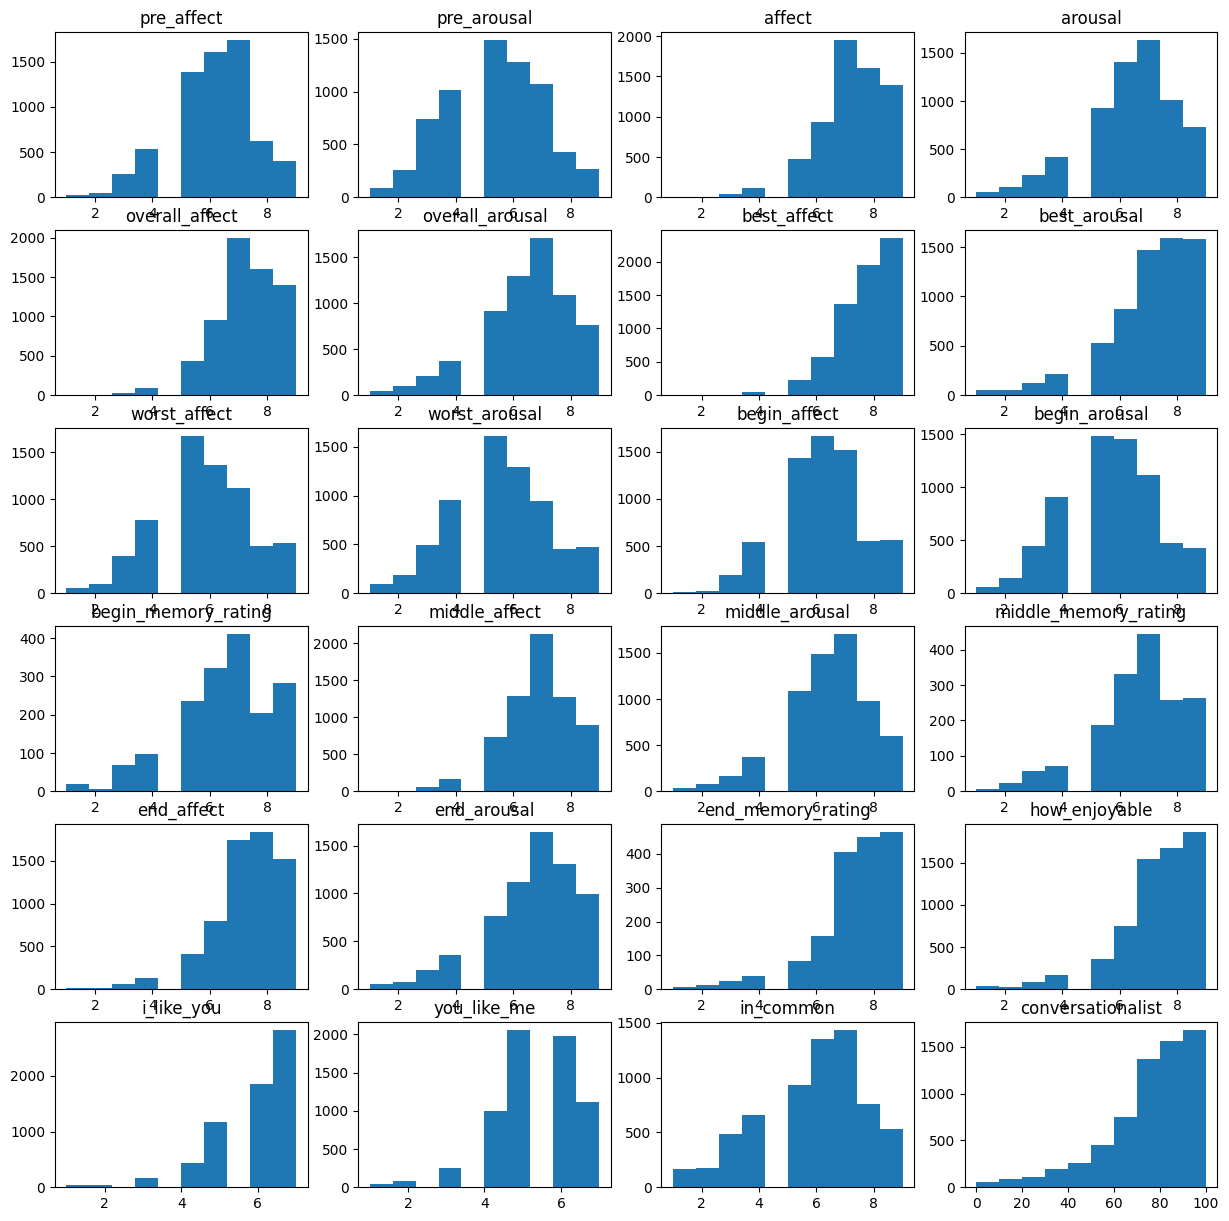

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6, 4, figsize=(15, 15))
indices = [[x for x in range(4)] for i in range(6)]
failed = []
a=0
for i in range(6):
  for j in range(4):
    try:
      col=outcomes[a]
      ax[i][j].hist(df[col])
      ax[i][j].set_title(col)
      a+=1
    except:
      failed.append(outcomes[i+j])
plt.show()

## Correlation

In [ ]:
df.corr().abs().unstack()

<ipython-input-8-659dea735276>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().abs().unstack()


survey_duration_in_seconds  survey_duration_in_seconds    1.000000
                            time_zone                     0.004787
                            pre_affect                    0.002322
                            pre_arousal                   0.004531
                            technical_quality             0.024250
                                                            ...   
backchannel_count           your_neurotic                 0.045480
                            your_open                     0.106328
                            backchannel_given             0.644520
                            backchannel_recieved          0.644520
                            backchannel_count             1.000000
Length: 43264, dtype: float64

In [ ]:
df_corr = df.corr()
df_corr

<ipython-input-22-0c96883f2151>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


,survey_duration_in_seconds,time_zone,pre_affect,pre_arousal,technical_quality,conv_length,affect,arousal,overall_affect,overall_arousal,...,my_neurotic,my_open,your_extraversion,your_agreeable,your_conscientious,your_neurotic,your_open,backchannel_given,backchannel_recieved,backchannel_count
survey_duration_in_seconds,1.000000,-0.004787,0.002322,0.004531,0.024250,0.013045,0.044957,0.038284,0.031892,0.014846,...,0.017332,0.042964,0.020508,0.011683,0.009083,-0.005055,0.022570,0.052040,0.052040,0.080743
time_zone,-0.004787,1.000000,-0.076723,-0.041572,0.031562,-0.016069,-0.040956,-0.018547,-0.034666,-0.027621,...,0.043340,-0.001687,-0.005596,-0.041952,-0.076166,0.074768,-0.004217,-0.003097,-0.003097,-0.004802
pre_affect,0.002322,-0.076723,1.000000,0.516117,-0.047226,0.035190,0.413807,0.355937,0.353099,0.310451,...,-0.374710,0.081580,0.054186,0.102637,0.111347,-0.116140,0.076069,0.010600,0.010600,0.016446
pre_arousal,0.004531,-0.041572,0.516117,1.000000,-0.040569,0.037791,0.309955,0.465021,0.263820,0.413382,...,-0.235210,0.039679,0.079791,0.047053,0.092143,-0.091882,0.074500,0.011133,0.011133,0.017273
technical_quality,0.024250,0.031562,-0.047226,-0.040569,1.000000,0.028162,-0.085644,-0.092416,-0.079950,-0.070530,...,0.085162,0.009590,-0.019616,-0.060525,-0.067760,0.053479,-0.036139,-0.034942,-0.034942,-0.054219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
your_neurotic,-0.005055,0.074768,-0.116140,-0.091882,0.053479,-0.026696,-0.225984,-0.167243,-0.250712,-0.172142,...,0.249494,-0.031300,-0.273169,-0.326340,-0.534990,1.000000,-0.276081,-0.029278,-0.029278,-0.045480
your_open,0.022570,-0.004217,0.076069,0.074500,-0.036139,0.028986,0.338657,0.197236,0.344653,0.220023,...,-0.038162,0.195991,0.247146,0.404513,0.358286,-0.276081,1.000000,0.068448,0.068448,0.106328
backchannel_given,0.052040,-0.003097,0.010600,0.011133,-0.034942,0.049505,0.108886,0.061068,0.087891,0.056081,...,-0.012217,0.032731,0.056760,0.070541,0.048483,-0.029278,0.068448,1.000000,-0.169189,0.644520
backchannel_recieved,0.052040,-0.003097,0.010600,0.011133,-0.034942,0.049505,0.108886,0.061068,0.087891,0.056081,...,-0.012217,0.032731,0.056760,0.070541,0.048483,-0.029278,0.068448,-0.169189,1.000000,0.644520


In [ ]:
sorted(df_corr["backchannel_count"].dropna())

[-0.13029943348481537,
 -0.12940733523315887,
 -0.12233728147843417,
 -0.12047196019965463,
 -0.09967122921867916,
 -0.09091497767802921,
 -0.08823444164481034,
 -0.08148792968718185,
 -0.08138983237439933,
 -0.07656047316344508,
 -0.06946066375255346,
 -0.06881323567720445,
 -0.06763500673342361,
 -0.06700281412656064,
 -0.0643853118500343,
 -0.06336461559124223,
 -0.057187263055358956,
 -0.056265966898658176,
 -0.05421896239368209,
 -0.0522875001175054,
 -0.052006244291882414,
 -0.05034659088273123,
 -0.048242241606186995,
 -0.04553989040611588,
 -0.045480138484762934,
 -0.045257202938005926,
 -0.044981256787897966,
 -0.04237721339142939,
 -0.03857202302335416,
 -0.03584383346413073,
 -0.035315562680308256,
 -0.034732529799832046,
 -0.03386246218963886,
 -0.029075783003717024,
 -0.027387850774235223,
 -0.026555536007397726,
 -0.022352882001655895,
 -0.0216297427940894,
 -0.020886496550466732,
 -0.020636546502320254,
 -0.018977947434130386,
 -0.018255355311274816,
 -0.0176855180621900

<Axes: >

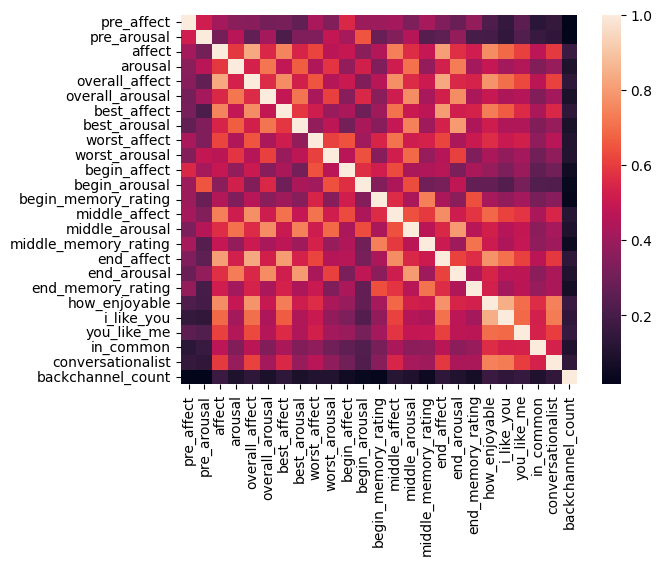

In [ ]:
sns.heatmap(df[outcomes+["backchannel_count"]].corr())

In [ ]:
figure = plt.figure(15, 15)
sns.heatmap(df.corr()[df.corr().abs()>0.6])


TypeError: ignored